In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean.cm as cm
import matplotlib.dates as mdates

# Data Import

In [2]:
temp_logged = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/stair_collab/julie_temperature/Temp_data_high_tide_combined.csv')

In [3]:
temp_logged

,Water_level_m,Date_UTC,Mean_temp_C,Site,Lat,Lon
0,3.148,2024-03-19 15:00,8.971429,Cain_peninsula,48.879148,-123.312558
1,3.575,2024-03-19 16:00,9.100000,Cain_peninsula,48.879148,-123.312558
2,3.850,2024-03-19 17:00,9.171429,Cain_peninsula,48.879148,-123.312558
3,3.949,2024-03-19 18:00,9.371429,Cain_peninsula,48.879148,-123.312558
4,3.883,2024-03-19 19:00,9.471429,Cain_peninsula,48.879148,-123.312558
...,...,...,...,...,...,...
23314,3.464,2024-09-17 14:00,14.750000,Sharon_cove,49.339260,-123.223257
23315,3.365,2024-09-17 14:10,14.800000,Sharon_cove,49.339260,-123.223257
23316,3.272,2024-09-17 14:20,14.800000,Sharon_cove,49.339260,-123.223257
23317,3.163,2024-09-17 14:30,14.883333,Sharon_cove,49.339260,-123.223257


In [4]:
site_coords = temp_logged.set_index('Site')[['Lat', 'Lon']].drop_duplicates().to_dict('index')

In [5]:
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]

In [6]:
model_loc = xr.open_dataset('/ocean/cdonaldson/stair_extractions/julie/SalishSeaCast_hourly_phys_00_05_dinner_20240320_20240927.nc')
# 2024-03-20 09:00:00
# 2024-09-27 08:30:00

# Functions

In [7]:
def grid_from_latlon(lat_coord, lon_coord):
    lat_diff = np.abs(bathy.nav_lat - lat_coord)
    lon_diff  = np.abs(bathy.nav_lon - lon_coord)
    sum_of_diff = lat_diff + lon_diff
    intersect_idx = np.unravel_index(np.nanargmin(np.ma.masked_array(sum_of_diff, mask=tmask[5]).filled(np.nan)), sum_of_diff.shape)

    fig, ax = plt.subplots(1,2)
    cb = ax[0].pcolormesh(sum_of_diff)
    ax[0].set_ylabel('GridY')
    ax[0].set_xlabel('GridX')
    viz_tools.set_aspect(ax[0]);
    
    cb2 = ax[1].pcolormesh(np.ma.masked_array(sum_of_diff, mask=tmask[5]))
    ax[1].set_ylabel('GridY')
    ax[1].set_xlabel('GridX')
    viz_tools.set_aspect(ax[1]);
    ax[1].plot(intersect_idx[1], intersect_idx[0], 'r*')

    fig.colorbar(cb, ax=ax[:], label='Lat Diff + Lon Diff')

    print('(y, x): {}'.format(intersect_idx))
    print('Bathy: {} m'.format(bathy['Bathymetry'].isel(y=intersect_idx[0], x=intersect_idx[1]).values))

In [8]:
def plot_water_levels(site_name):
    temp_logged_site = temp_logged[temp_logged['Site'] == site_name]
    temp_logged_site['time'] = pd.to_datetime(temp_logged_site['Date_UTC'], format='%Y-%m-%d %H:%M')

    fig, ax = plt.subplots(1,1)
    ax.plot(temp_logged_site['time'], temp_logged_site['Water_level_m'], '-')
    print(temp_logged_site['time'].min())
    print(temp_logged_site['time'].max())
    print(len(temp_logged_site['time']))

    return temp_logged_site

In [9]:
def plot_temp_ts(temp_logged_site):

    fig, ax = plt.subplots(1,1)
    ax.plot(temp_logged_site['time'], temp_logged_site['Mean_temp_C'], '-')
    print(temp_logged_site['Mean_temp_C'].min())
    print(temp_logged_site['Mean_temp_C'].max())

In [10]:
def bias(obs, mod):
    return np.mean(mod - obs)

In [11]:
def rmse(obs, mod):
    return (np.sqrt(((mod - obs)**2).mean()))

In [12]:
def check_depth_stats(site_name, dep_sel, model_loc_filt_time, temp_logged_loc):
    model_loc_filt_time_dep_sel = model_loc_filt_time.isel(depth=dep_sel)
    
    diff_loc_sel = model_loc_filt_time_dep_sel.votemper[:,0,0].values - temp_logged_loc['Mean_temp_C']
    bias_loc_sel = round(bias(temp_logged_loc['Mean_temp_C'], model_loc_filt_time_dep_sel.votemper[:,0,0].values),2)
    rmse_loc_sel = round(rmse(temp_logged_loc['Mean_temp_C'], model_loc_filt_time_dep_sel.votemper[:,0,0].values),2)

    fig, ax = plt.subplots(1,1, figsize=(8, 2))
    ax.plot(temp_logged_loc['time'], diff_loc_sel,'.', markersize=2, color='k', label='residuals')
    ax.hlines(0, temp_logged_loc['time'].min(), temp_logged_loc['time'].max(), color='r', zorder=0)
    ax.set_ylabel(r'Temperature [$^\circ$C]')
    ax.set_title('{}\nResiduals [mod - obs] for depth = {}\nBias: {}\nRMSE: {}'.format(site_name, round(float(model_loc.depth[dep_sel]), 1), bias_loc_sel, rmse_loc_sel))
    ax.legend()

    return(bias_loc_sel, rmse_loc_sel)


# Model-Logger Evaluations

## Dinner Bay

Dinner_bay
(y, x): (377, 256)
Bathy: 39.0625 m
2024-03-20 09:00:00
2024-09-27 08:30:00
3163
8.685714286
17.8125
8.685714286
17.8125


/tmp/ipykernel_805388/1811648375.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_logged_site['time'] = pd.to_datetime(temp_logged_site['Date_UTC'], format='%Y-%m-%d %H:%M')


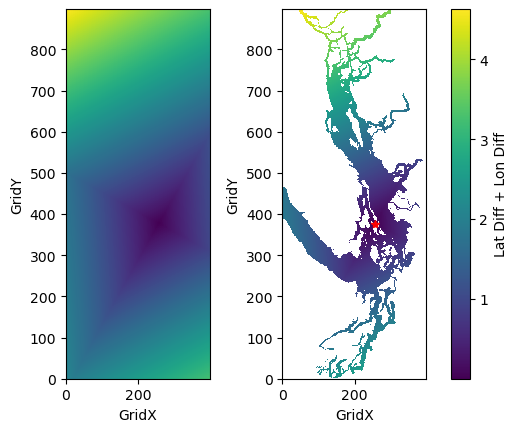

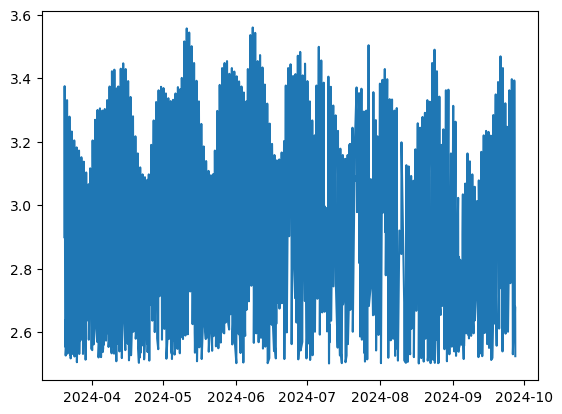

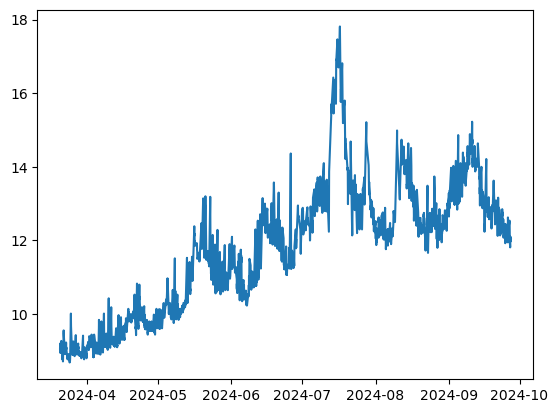

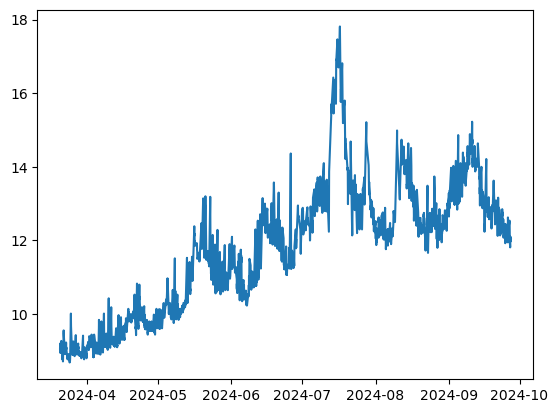

In [13]:
site_name = 'Dinner_bay'
lat, lon = site_coords[site_name].values()
print(site_name)
grid_from_latlon(lat, lon)
temp_logged_loc_preserve = plot_water_levels(site_name)
plot_temp_ts(temp_logged_loc_preserve)
# temp_logged_loc_preserve.loc[temp_logged_loc_preserve['Mean_temp_C'] >= 20, 'Mean_temp_C'] = np.nan
temp_logged_loc_preserve.loc[temp_logged_loc_preserve['Mean_temp_C'].diff().abs() > 5, 'Mean_temp_C'] = np.nan
plot_temp_ts(temp_logged_loc_preserve)

In [14]:
temp_logged_loc_preserve # values every half hour; need to condense this so that it it one value per hour

,Water_level_m,Date_UTC,Mean_temp_C,Site,Lat,Lon,time
3758,2.899,2024-03-20 09:00,9.057143,Dinner_bay,48.83714,-123.323925,2024-03-20 09:00:00
3759,3.072,2024-03-20 09:30,9.057143,Dinner_bay,48.83714,-123.323925,2024-03-20 09:30:00
3760,3.209,2024-03-20 10:00,9.142857,Dinner_bay,48.83714,-123.323925,2024-03-20 10:00:00
3761,3.305,2024-03-20 10:30,9.200000,Dinner_bay,48.83714,-123.323925,2024-03-20 10:30:00
3762,3.360,2024-03-20 11:00,9.114286,Dinner_bay,48.83714,-123.323925,2024-03-20 11:00:00
...,...,...,...,...,...,...,...
6916,2.680,2024-09-27 06:30,12.012500,Dinner_bay,48.83714,-123.323925,2024-09-27 06:30:00
6917,2.671,2024-09-27 07:00,12.000000,Dinner_bay,48.83714,-123.323925,2024-09-27 07:00:00
6918,2.644,2024-09-27 07:30,12.000000,Dinner_bay,48.83714,-123.323925,2024-09-27 07:30:00
6919,2.596,2024-09-27 08:00,12.012500,Dinner_bay,48.83714,-123.323925,2024-09-27 08:00:00


In [15]:
temp_logged_loc = temp_logged_loc_preserve[['time', 'Water_level_m', 'Mean_temp_C']].groupby(pd.Grouper(key='time', freq='1H')).mean().reset_index()
temp_logged_loc

,time,Water_level_m,Mean_temp_C
0,2024-03-20 09:00:00,2.9855,9.057143
1,2024-03-20 10:00:00,3.2570,9.171429
2,2024-03-20 11:00:00,3.3675,9.071429
3,2024-03-20 12:00:00,3.3320,8.992857
4,2024-03-20 13:00:00,3.1930,8.985714
...,...,...,...
4579,2024-09-27 04:00:00,2.6570,12.043750
4580,2024-09-27 05:00:00,2.6630,11.987500
4581,2024-09-27 06:00:00,2.6785,12.012500
4582,2024-09-27 07:00:00,2.6575,12.000000


In [16]:
times_loc = temp_logged_loc['time'].unique()
model_loc_filt_time = model_loc.sel(time=times_loc, method='nearest', tolerance='30min')  # because the model is at the half-hour and the logger is at the hour

In [17]:
mean_logged_lvl_loc = temp_logged_loc['Water_level_m'].mean()
print(mean_logged_lvl_loc)
model_loc_filt_time_depmean = model_loc_filt_time.sel(depth=mean_logged_lvl_loc, method='nearest')  # only includes time values that have a corresponding logger val

dep_sel = 0
model_loc_filt_time_dep_sel = model_loc_filt_time.isel(depth=dep_sel)

model_loc_depmean = model_loc.sel(depth=mean_logged_lvl_loc, method='nearest')  # includes all time values , fills in logger gaps

2.9547186181434597


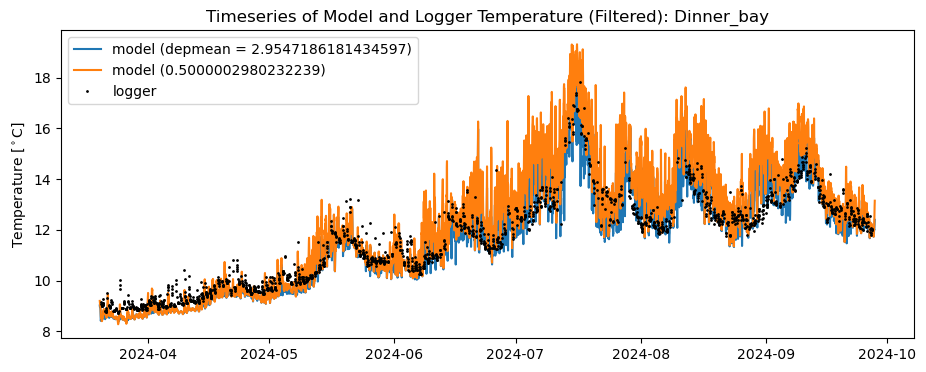

In [18]:
fig, ax = plt.subplots(1,1, figsize=(11, 4))
ax.plot(model_loc_depmean.time, model_loc_depmean.votemper[:,:,0], label='model (depmean = {})'.format(mean_logged_lvl_loc))
ax.plot(model_loc.time, model_loc.votemper[:,dep_sel,0,0], label='model ({})'.format(model_loc.depth[dep_sel].values))
# ax.plot(model_loc.time, model_loc.votemper[:,4,0,0], label='model (4.5)')
ax.plot(temp_logged_loc['time'], temp_logged_loc['Mean_temp_C'],'.', markersize=2, color='k', label='logger')
ax.set_ylabel(r'Temperature [$^\circ$C]')
ax.set_title('Timeseries of Model and Logger Temperature (Filtered): {}'.format(site_name))
ax.legend()

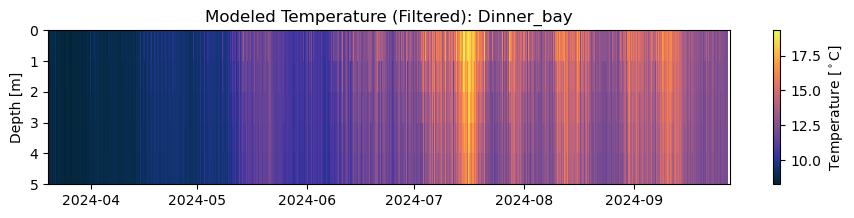

In [19]:
cmap = cm.thermal
fig, ax = plt.subplots(1,1, figsize=(11, 2))
colors = ax.pcolormesh(model_loc_filt_time.reindex_like(model_loc).time, model_loc_filt_time.reindex_like(model_loc).depth, model_loc_filt_time.reindex_like(model_loc).votemper[:,:,0,0].T, cmap=cmap)
ax.set_ylim([5,0])
ax.set_title('Modeled Temperature (Filtered): {}'.format(site_name))
ax.set_ylabel('Depth [m]')
cb = fig.colorbar(colors, ax=ax, label=r'Temperature [$^\circ$C]', orientation='vertical')

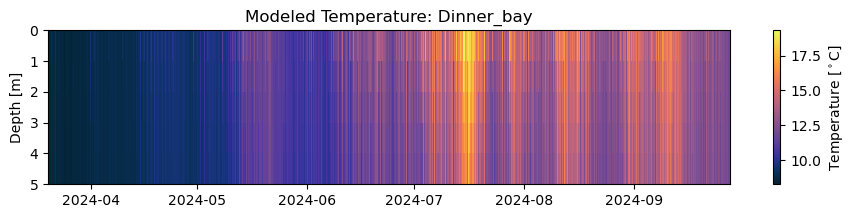

In [20]:
cmap = cm.thermal
fig, ax = plt.subplots(1,1, figsize=(11, 2))
colors = ax.pcolormesh(model_loc.time, model_loc.depth, model_loc.votemper[:,:,0,0].T, cmap=cmap)
ax.set_ylim([5,0])
ax.set_title('Modeled Temperature: {}'.format(site_name))
ax.set_ylabel('Depth [m]')
cb = fig.colorbar(colors, ax=ax, label=r'Temperature [$^\circ$C]', orientation='vertical')

### Dep Mean

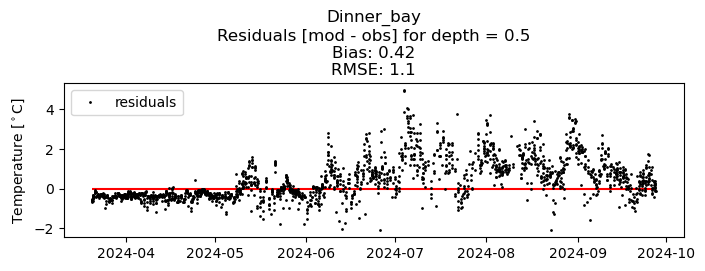

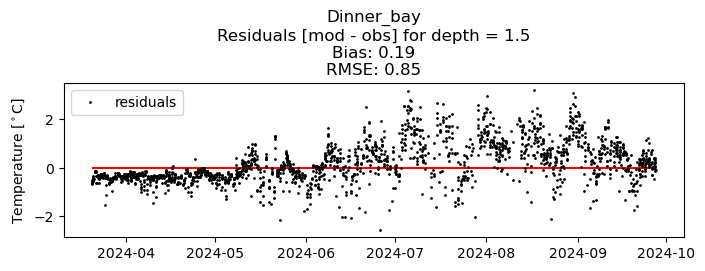

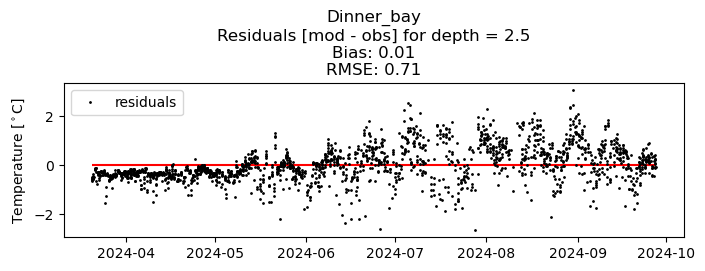

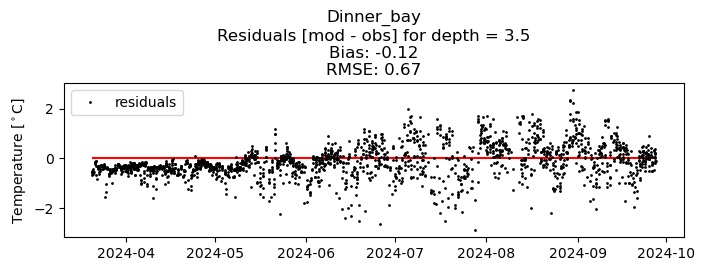

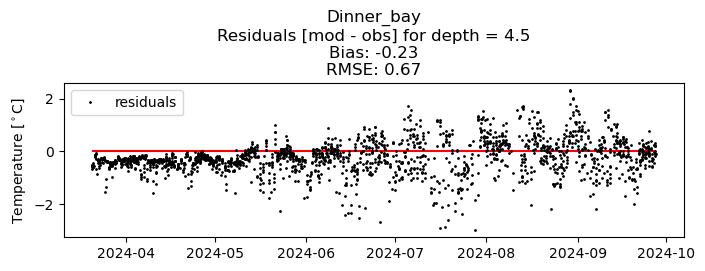

In [21]:
bias_list = np.zeros(5)
rmse_list = np.zeros(5)

for dep in np.arange(5):
    b, r = check_depth_stats(site_name, dep, model_loc_filt_time, temp_logged_loc)
    bias_list[dep] = b
    rmse_list[dep] = r

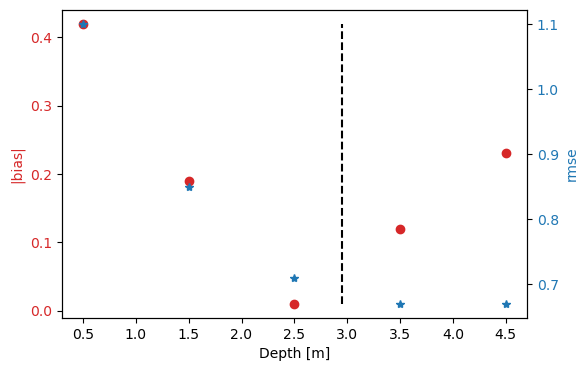

In [22]:
depth_arr = np.round(np.array(model_loc.depth),2)

fig, ax1 = plt.subplots(1,1, figsize=(6, 4))
ax1.set_xlabel('Depth [m]')

color = 'tab:red'
ax1.plot(depth_arr, np.abs(bias_list), color=color, marker='o', linestyle='')
ax1.set_ylabel('|bias|', color=color)
ax1.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
ax2 = ax1.twinx()
ax2.plot(depth_arr, rmse_list, color=color, marker='*', linestyle='')
ax2.set_ylabel('rmse', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.vlines(mean_logged_lvl_loc, min(rmse_list), max(rmse_list), color='k', linestyle='--')

In [23]:
dep_sel = 2

# Visualizations and Timeseries

## Functions

In [24]:
color_sal = '#25738a'
color_temp = '#cc5e0f'

In [25]:
def plot_timeseries(daily_xr, site_name):
    fig, ax = plt.subplots(2,1,  figsize = (12,3), sharex=True)
    fig.suptitle(site_name)

    ax[0].plot(daily_xr['time'], daily_xr.vosaline, color=color_sal, alpha=1)
    ax[0].set_ylabel('Salinity [g/kg]')
    ax[0].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
    ax[0].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))

    ax[1].plot(daily_xr['time'], daily_xr.votemper, color=color_temp, alpha=1)
    ax[1].set_ylabel('Temperature [degC]')
    ax[1].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
    ax[1].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))
    ax[1].set_xlim([daily_xr['time'].min(), daily_xr['time'].max()])

In [26]:
def make_df(daily_xr):
    vars_loc_df = daily_xr.to_dataframe().drop(columns=['depth', 'gridY', 'gridX']).reset_index()
    vars_loc_df['month-day'] = vars_loc_df['time'].dt.strftime('%m-%d')
    vars_loc_df['year'] = vars_loc_df['time'].dt.strftime('%Y')

    vars_loc_df_mean = vars_loc_df.groupby('month-day').mean(numeric_only=True).reset_index()

    return vars_loc_df, vars_loc_df_mean

In [27]:
def plot_stacked_timeseries(vars_loc_df, vars_loc_df_mean, site_name):
    fig, ax = plt.subplots(2,1,  figsize = (12,3), sharex=True)
    fig.suptitle(site_name)

    vars_loc_df['month-day'] = pd.to_datetime('2001-' + vars_loc_df['month-day'], errors='coerce')
    vars_loc_df_mean['month-day'] = pd.to_datetime('2001-' + vars_loc_df_mean['month-day'], errors='coerce')

    for year in vars_loc_df['year'].unique():

        ax[0].plot(vars_loc_df[vars_loc_df['year'] == year]['month-day'], vars_loc_df[vars_loc_df['year'] == year]['vosaline'], color=color_sal, alpha=0.3)
        ax[0].set_ylabel('Salinity [g/kg]')
        ax[0].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
        ax[0].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))

        ax[1].plot(vars_loc_df[vars_loc_df['year'] == year]['month-day'], vars_loc_df[vars_loc_df['year'] == year]['votemper'], color=color_temp, alpha=0.3)
        ax[1].set_ylabel('Temperature [degC]')
        ax[1].grid(axis='y', color='#737373', linestyle=(0, (1, 10)))
        ax[1].grid(axis='x', color='#737373', linestyle=(0, (1, 10)))
        
        ax[1].set_xlim([vars_loc_df['month-day'].min(), vars_loc_df['month-day'].max()])
        ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        # ax[1].set_xticks(['01-01', '02-01', '03-01', '04-01', '05-01', '06-01', '07-01', '08-01', '09-01', '10-01', '11-01', '12-01', '12-31'])

    ax[0].plot(vars_loc_df_mean['month-day'], vars_loc_df_mean['vosaline'], color='k', alpha=1)
    ax[1].plot(vars_loc_df_mean['month-day'], vars_loc_df_mean['votemper'], color='k', alpha=1)

In [28]:
def plot_hist(vars_loc_df, site_name):

    bin_num = 15

    fig, ax = plt.subplots(1,2, figsize = (12, 3), sharex=True)
    # fig.tight_layout(pad=1.6)
    fig.suptitle(site_name)

    ax[0].set_ylabel(r'Salinity [g/kg]')
    ax[0].hist(vars_loc_df['vosaline'], bins=bin_num, color=color_sal, edgecolor='black', orientation='horizontal')

    ax[1].set_ylabel(r'Temperature $^{\circ}$C')
    ax[1].set_xlabel(r'# Days')
    ax[1].hist(vars_loc_df['votemper'], bins=bin_num, color=color_temp, edgecolor='black', orientation='horizontal')

In [29]:
def print_stats(vars_loc_df):
    print('---- Salinity ---------------- \n\
    Mean:               {:.2f} (g/kg) \n\
    Median:             {:.2f} (g/kg) \n\
    Standard Deviation: {:.2f} (g/kg)'.format(vars_loc_df['vosaline'].mean(), np.median(vars_loc_df['vosaline']), vars_loc_df['vosaline'].std()))

    print('---- Temperature ---------------- \n\
    Mean:               {:.2f} (degC) \n\
    Median:             {:.2f} (degC) \n\
    Standard Deviation: {:.2f} (degC)'.format(vars_loc_df['votemper'].mean(), np.median(vars_loc_df['votemper']), vars_loc_df['votemper'].std()))

## Analysis and Figures

In [30]:
model_daily = xr.open_dataset('/ocean/cdonaldson/stair_extractions/julie/SalishSeaCast_daily_phys_00_05_dinner_20150101_20241231.nc').isel(depth=dep_sel, gridX=0, gridY=0)

---- Salinity ---------------- 
    Mean:               28.41 (g/kg) 
    Median:             28.85 (g/kg) 
    Standard Deviation: 1.50 (g/kg)
---- Temperature ---------------- 
    Mean:               10.53 (degC) 
    Median:             10.09 (degC) 
    Standard Deviation: 2.45 (degC)


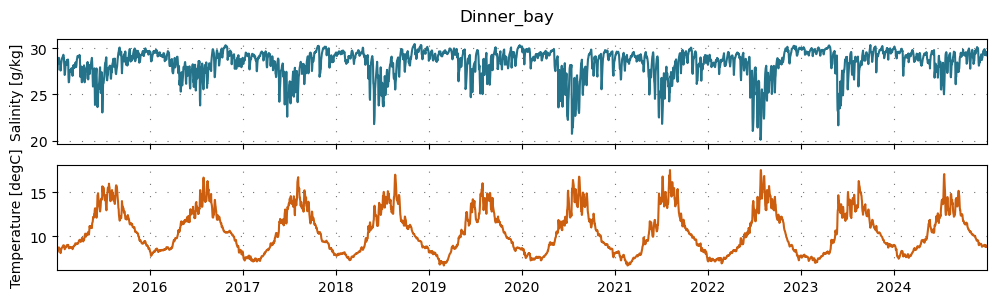

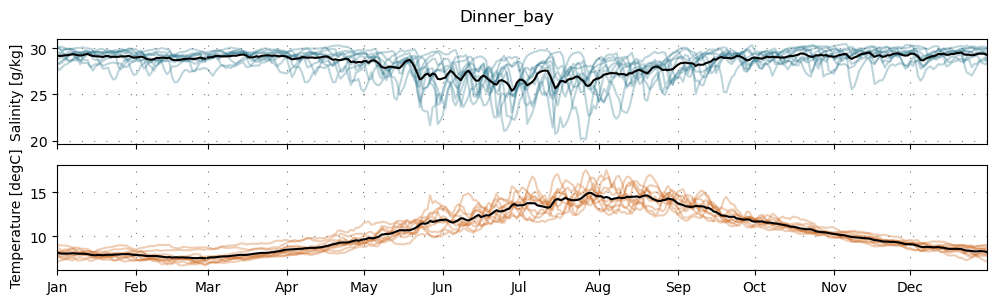

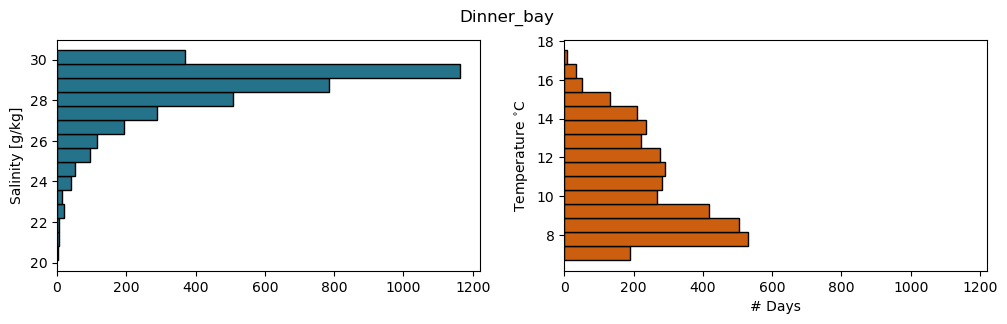

In [31]:
vars_loc_df, vars_loc_df_mean = make_df(model_daily)
print_stats(vars_loc_df)
plot_timeseries(model_daily, site_name)
plot_stacked_timeseries(vars_loc_df, vars_loc_df_mean, site_name)
plot_hist(vars_loc_df, site_name)

In [32]:
model_daily_alldep = xr.open_dataset('/ocean/cdonaldson/stair_extractions/julie/SalishSeaCast_daily_phys_00_05_dinner_20150101_20241231.nc').isel(gridX=0, gridY=0)

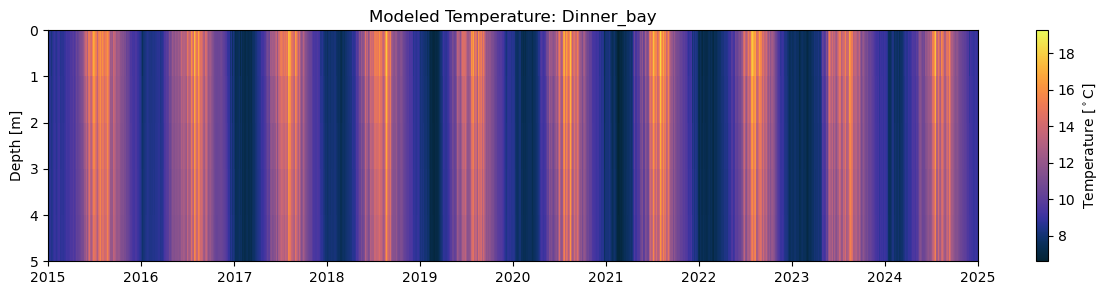

In [33]:
cmap = cm.thermal
fig, ax = plt.subplots(1,1, figsize=(15, 3))
colors = ax.pcolormesh(model_daily_alldep.time, model_daily_alldep.depth, model_daily_alldep.votemper[:,:].T, cmap=cmap)
ax.set_ylim([5,0])
ax.set_title('Modeled Temperature: {}'.format(site_name))
ax.set_ylabel('Depth [m]')
cb = fig.colorbar(colors, ax=ax, label=r'Temperature [$^\circ$C]', orientation='vertical')

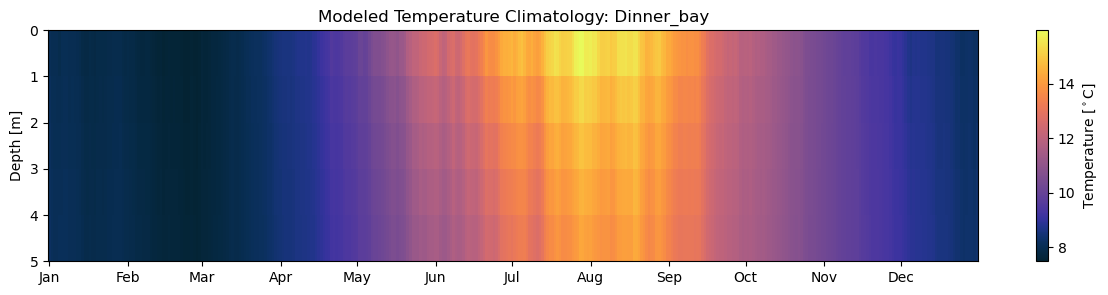

In [34]:
model_daily_alldep.coords['dayofyear'] = model_daily_alldep['time'].dt.dayofyear
daily_climatology = model_daily_alldep.groupby('dayofyear').mean('time')
days = pd.date_range('2000-01-01', '2000-12-31')
daily_climatology = daily_climatology.assign_coords(time=('dayofyear', days))

cmap = cm.thermal
fig, ax = plt.subplots(1,1, figsize=(15, 3))
colors = ax.pcolormesh(daily_climatology.time, daily_climatology.depth, daily_climatology.votemper[:,:].T, cmap=cmap)
ax.set_ylim([5,0])
ax.set_title('Modeled Temperature Climatology: {}'.format(site_name))
ax.set_ylabel('Depth [m]')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
cb = fig.colorbar(colors, ax=ax, label=r'Temperature [$^\circ$C]', orientation='vertical')